We are using the ozone level detection dataset by Kun Zhang,Wei Fan and XiaoJing Yuan.
https://archive.ics.uci.edu/ml/datasets/Ozone+Level+Detection

The task is to find level of ozone in the atmosphere on a given day and time based on sensor data like temperature, humidity, wind speed, precipitation and sea level pressure. 
The output is a binary variable with 0 standing for low ozone level and 1 standing for high ozone level. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

# **Understanding the Data and Data Cleaning**

Dataset Information: \\
Tx: All features starting with T represent the temperature (Fahrenheit) measured at different times of the day. \\
WSRx: All features starting with WS represent wind speeds(m/s) at various times. \\
WSR_PK: peak wind speed

WSR_AV: average wind speed

T_PK: Peak T \\
T_AV: Average T \\
T85:  T at 850 hpa level (or about 1500 m height) \\
RH85: Relative Humidity at 850 hpa (in percentage) \\
U85:  (U wind - east-west direction wind at 850 hpa) \\
V85:  V wind - N-S direction wind at 850 \\
HT85: Geopotential height at 850 hpa, it is about the same as height at low altitude \\
T70:  T at 700 hpa level (roughly 3100 m height) \\
KI:  K-Index. A measure of the thunderstorm potential based on vertical temperature lapse rate, moisture content of the lower atmosphere, and the vertical extent of the moist layer. https://w1.weather.gov/glossary/index.php?letter=k  \\
TT:  T-Totals. an index used to assess storm strength. http://www.theweatherprediction.com/habyhints/302/   \\

SLP: Sea level pressure (psi) \\
SLP_: SLP change from previous day \\

Precp: precipitation \\



Output:
Result: High Ozone level(1) or Low Ozone level(0)

In [ ]:
data = pd.read_csv('eighthr.csv',header=0) # Specify the correct file path

In [ ]:
#display the first 5 rows of the data
data.head()

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Result
0,1/1/1998,0.8,1.8,2.4,2.1,2,2.1,1.5,1.7,1.9,...,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0,0
1,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0
2,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0
3,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,...,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0
4,1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,...,?,?,?,?,?,?,?,?,0.58,0


In [ ]:
#get information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 74 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2534 non-null   object
 1   WSR0    2534 non-null   object
 2   WSR1    2534 non-null   object
 3   WSR2    2534 non-null   object
 4   WSR3    2534 non-null   object
 5   WSR4    2534 non-null   object
 6   WSR5    2534 non-null   object
 7   WSR6    2534 non-null   object
 8   WSR7    2534 non-null   object
 9   WSR8    2534 non-null   object
 10  WSR9    2534 non-null   object
 11  WSR10   2534 non-null   object
 12  WSR11   2534 non-null   object
 13  WSR12   2534 non-null   object
 14  WSR13   2534 non-null   object
 15  WSR14   2534 non-null   object
 16  WSR15   2534 non-null   object
 17  WSR16   2534 non-null   object
 18  WSR17   2534 non-null   object
 19  WSR18   2534 non-null   object
 20  WSR19   2534 non-null   object
 21  WSR20   2534 non-null   object
 22  WSR21   2534 non-null   

In [ ]:
#the date column serves no purpose for the analysis. Hence we drop it from the data, inplace=True shifts all the other columns to the left
data.drop(columns='Date', inplace=True)

In [ ]:
#use the .replace() to replace all instances of '?' with NaN
data.replace(to_replace='?', value=np.nan, inplace=True)

In [ ]:
#You can check if there are any NaN values in the features using .isna() function
print(data["T_PK"].isna().value_counts())

False    2359
True      175
Name: T_PK, dtype: int64


In [ ]:
# We will only be using a few features for the analysis. Here we split the data into input features and output response. 
#If the columns are labelled, the you can select them by just specifying their names. This is particularly useful when you have to pick only a certain features out of 100s of given features.
#instead of specifying indices
X = data[['WSR_AV','T_AV','T85','RH85','SLP','Precp']] 
Y = data.iloc[:,-1].values  #select the last column as the output variable

Now that we have our Input and Output Variables set, the next task is to deal with the NaN values in the input. Previously we dealt with NaN by dropping out the rows that contained NaN. This is a very simple approach and works fine for most data. 

But in a situation where the amount of data is already scarce, it would be infeasible to drop additional rows from it. Hence we need another strategy to deal with such a situation. 

Here we use a simple but highly efficient method of replacing all the NaN values in a column by the mean value of the column. Though not an acccurate representation of the values, this method still gives very good results.

In [ ]:
#we will make use of sklearn's SimpleImputer function to replace the NaN with the mean values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [ ]:
#use the imputer instance to transform the data
data = pd.DataFrame(imputer.fit_transform(data), dtype='float64')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,...,0.150000,10.670000,-1.560000,5795.000000,-12.100000,17.900000,10330.000000,-55.000000,0.00,0.0
1,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,...,0.480000,8.390000,3.840000,5805.000000,14.050000,29.000000,10275.000000,-55.000000,0.00,0.0
2,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,...,0.600000,6.940000,9.800000,5790.000000,17.900000,41.300000,10235.000000,-40.000000,0.00,0.0
3,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,...,0.490000,8.730000,10.540000,5775.000000,31.150000,51.700000,10195.000000,-40.000000,2.08,0.0
4,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,...,0.304716,9.872418,0.830116,5818.821222,10.511051,37.388335,10164.198442,-0.119949,0.58,0.0


In [ ]:
#transform X by replacing the NaN values and converting it into a pandas DataFrame
X = pd.DataFrame(imputer.fit_transform(X))
#Assign Column Labels to each column of X
X.columns=['Average Wind Speed','Average Temperature','Temeperature at 85 hpa','Relative Humidity at 85hpa','Sea Level Pressure','Precipitation']
X

,Average Wind Speed,Average Temperature,Temeperature at 85 hpa,Relative Humidity at 85hpa,Sea Level Pressure,Precipitation
0,3.1,12.5,6.700000,0.11000,10330.000000,0.00
1,3.4,17.8,9.000000,0.25000,10275.000000,0.00
2,3.5,18.7,9.000000,0.56000,10235.000000,0.00
3,3.2,18.7,9.900000,0.89000,10195.000000,2.08
4,2.3,21.1,13.575298,0.57732,10164.198442,0.58
...,...,...,...,...,...,...
2529,1.6,7.7,5.500000,0.33000,10295.000000,0.00
2530,2.6,12.9,5.800000,0.27000,10310.000000,0.00
2531,1.9,17.7,7.500000,0.79000,10275.000000,0.00
2532,2.1,19.9,9.300000,0.66000,10245.000000,0.05


In [ ]:
X.shape

(2534, 6)

# **Data Visualization**

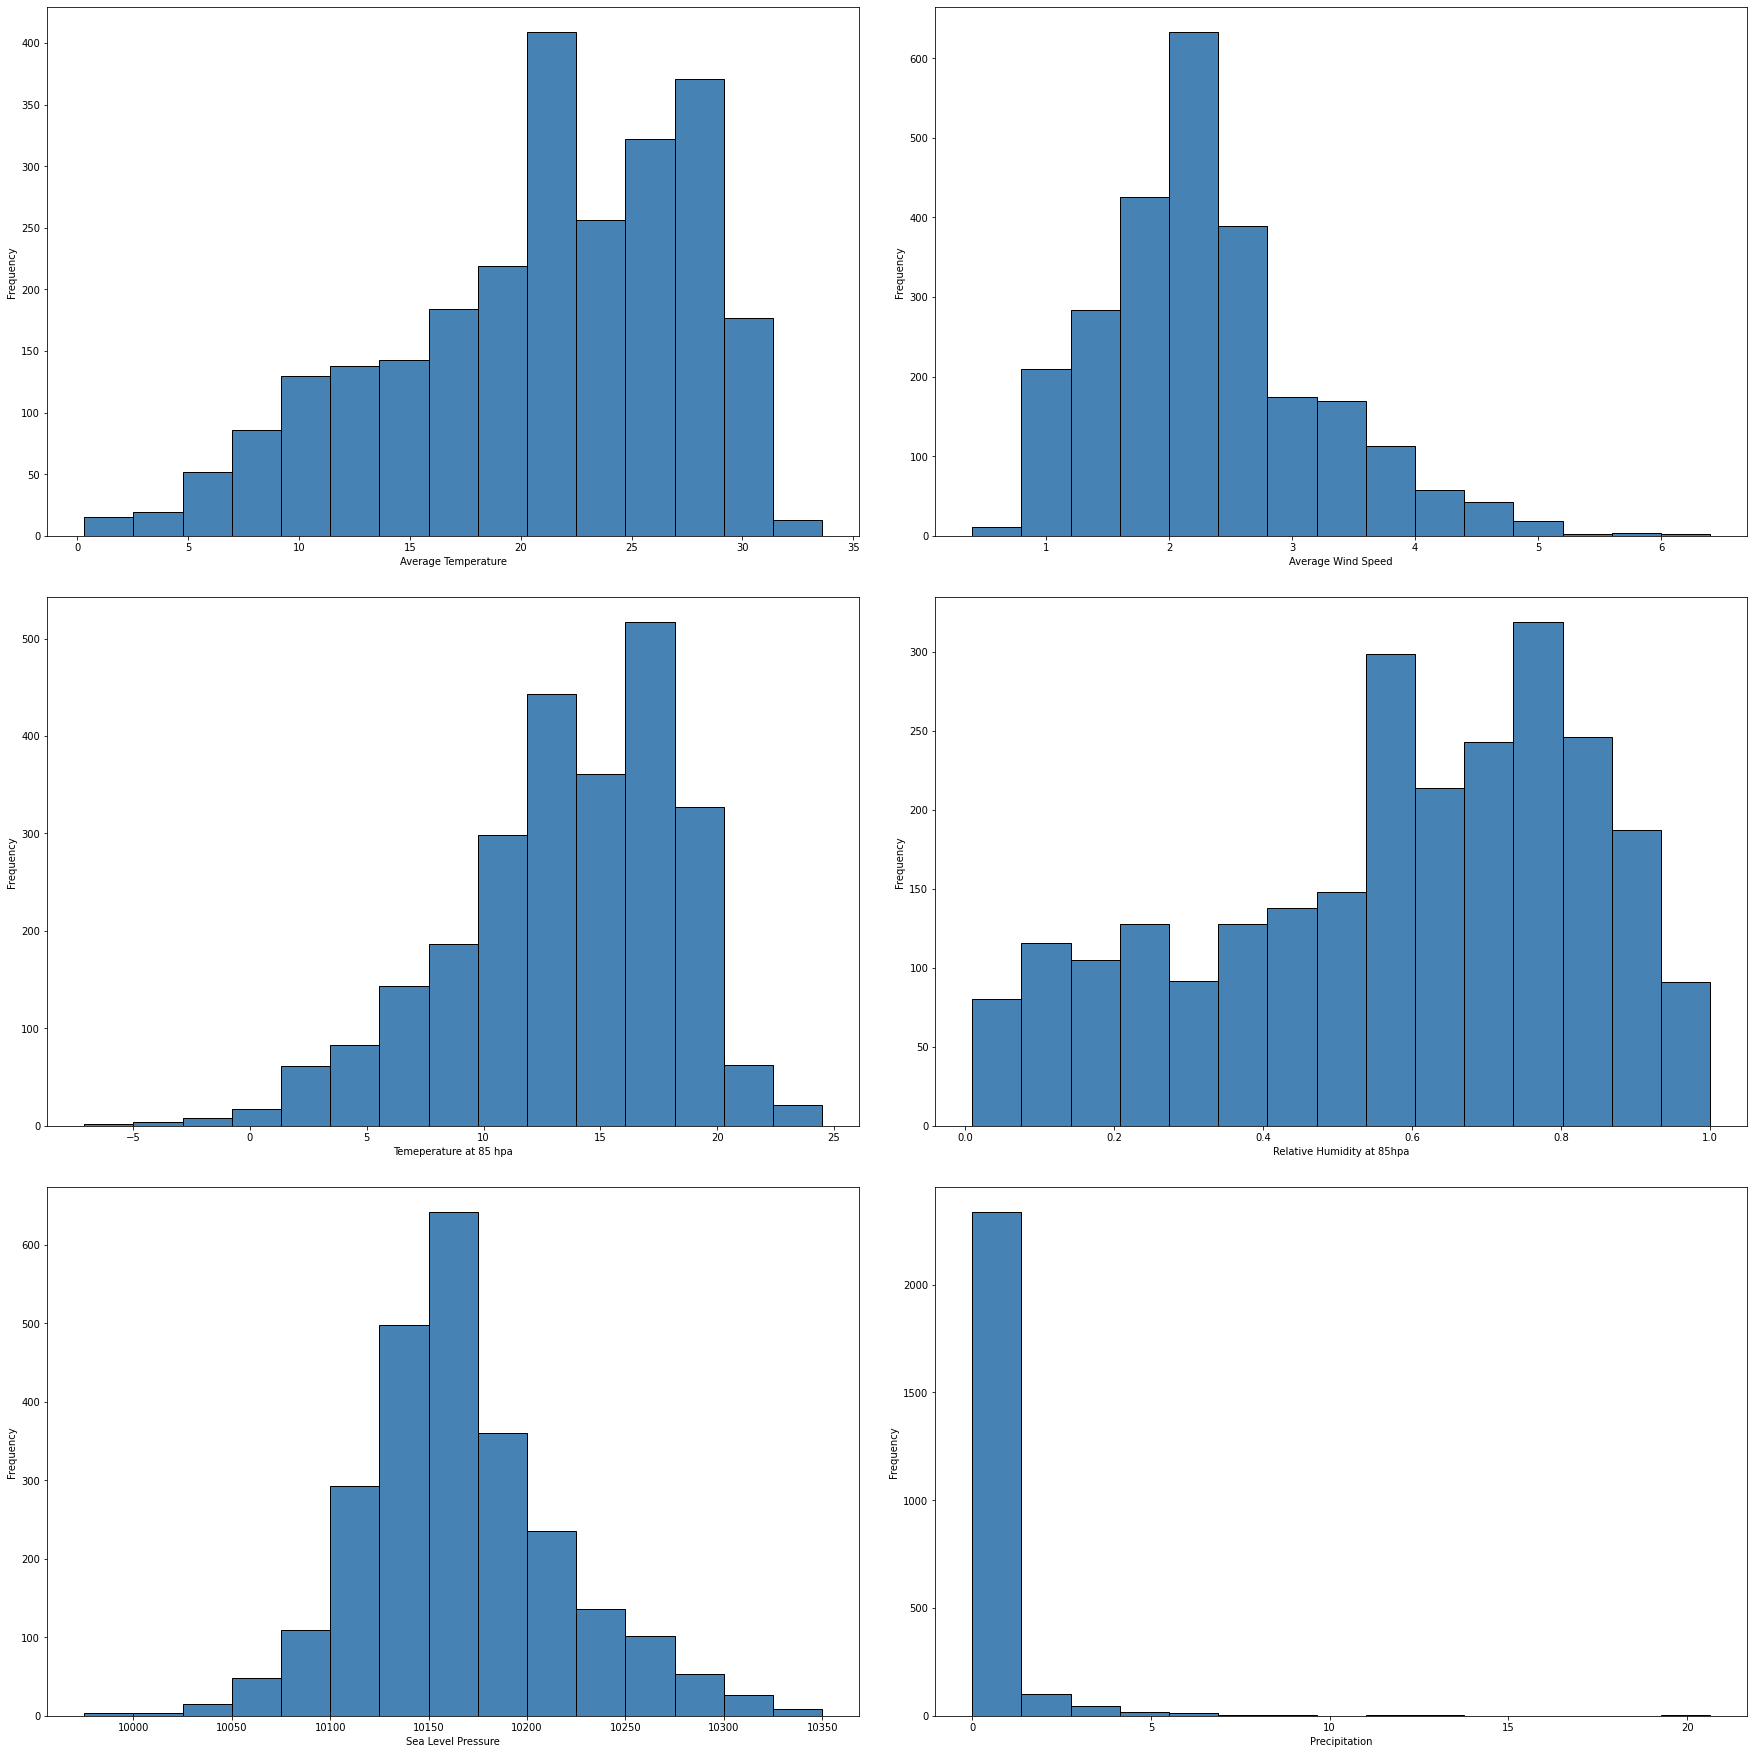

In [ ]:
fig = plt.figure(figsize = (25,25))
#fig.subplots_adjust(top=0.85, wspace=0.3)

# Histogram
ax = fig.add_subplot(3, 2, 1)   # no of rows, no.of columns, index of the plot 1
ax.set_xlabel("Average Temperature")
ax.set_ylabel("Frequency") 
freq, bins, patches = ax.hist(X['Average Temperature'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)

ax = fig.add_subplot(3, 2, 2)
ax.set_xlabel("Average Wind Speed")
ax.set_ylabel("Frequency") 
freq, bins, patches = ax.hist(X['Average Wind Speed'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)

ax = fig.add_subplot(3, 2, 3)
ax.set_xlabel("Temeperature at 85 hpa")
ax.set_ylabel("Frequency") 
freq, bins, patches = ax.hist(X['Temeperature at 85 hpa'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)

ax = fig.add_subplot(3, 2, 4)
ax.set_xlabel("Relative Humidity at 85hpa")
ax.set_ylabel("Frequency") 
freq, bins, patches = ax.hist(X['Relative Humidity at 85hpa'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)

ax = fig.add_subplot(3, 2, 5)
ax.set_xlabel("Sea Level Pressure")
ax.set_ylabel("Frequency") 
freq, bins, patches = ax.hist(X['Sea Level Pressure'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)

ax = fig.add_subplot(3, 2, 6)
ax.set_xlabel("Precipitation")
ax.set_ylabel("Frequency") 
freq, bins, patches = ax.hist(X['Precipitation'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)
fig. tight_layout(pad=3.0)

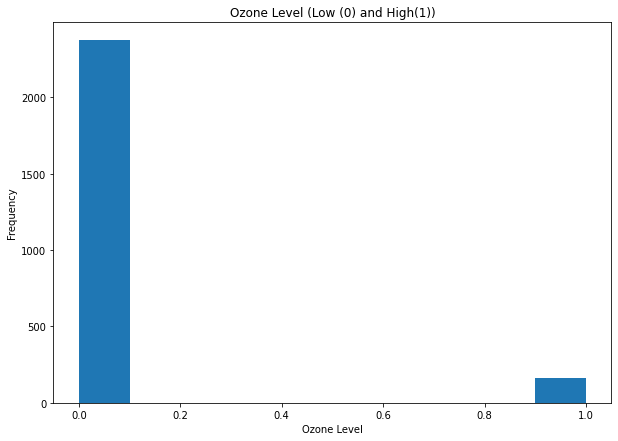

In [ ]:
fig = plt.figure(figsize =(10, 7)) 
  
plt.hist(Y)  
plt.xlabel('Ozone Level')
plt.ylabel('Frequency')  
plt.title("Ozone Level (Low (0) and High(1))")  
  
# show plot 
plt.show() 
# 0 means low ozone level and 1 means high ozone level. It is good that most of the data show ozone levels are in the alloable limits. 

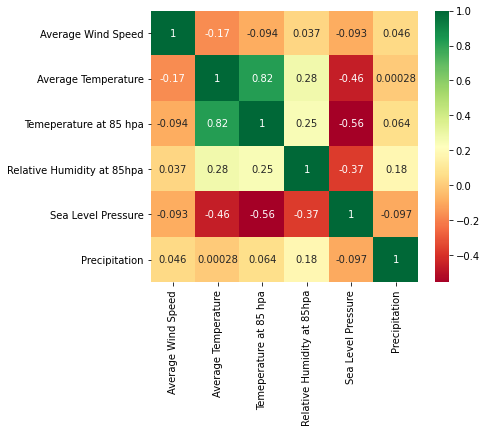

In [ ]:
plt.figure(figsize=(6,5))  # set the size of the figure 
p=sns.heatmap(X.corr(), annot=True,cmap ='RdYlGn')  # we use the seaborn library to plot the heatmap.

In [ ]:
X.describe()

,Average Wind Speed,Average Temperature,Temeperature at 85 hpa,Relative Humidity at 85hpa,Sea Level Pressure,Precipitation
count,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000
mean,2.314949,20.840483,13.575298,0.577320,10164.198442,0.372026
std,0.871756,6.766376,4.777721,0.252778,51.428116,1.317438
min,0.400000,0.300000,-7.100000,0.010000,9975.000000,0.000000
25%,1.700000,16.500000,10.700000,0.400000,10130.000000,0.000000
50%,2.300000,21.400000,14.100000,0.620000,10160.000000,0.000000
75%,2.800000,26.500000,17.300000,0.790000,10190.000000,0.050000
max,6.400000,33.600000,24.500000,1.000000,10350.000000,20.650000


# **Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

**Data Preprocessing for Naive Bayes**

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = pd.DataFrame(min_max_scaler.fit_transform(X))
x_scaled.head()

,0,1,2,3,4,5
0,0.450000,0.366366,0.436709,0.101010,0.946667,0.000000
1,0.500000,0.525526,0.509494,0.242424,0.800000,0.000000
2,0.516667,0.552553,0.509494,0.555556,0.693333,0.000000
3,0.466667,0.552553,0.537975,0.888889,0.586667,0.100726
4,0.316667,0.624625,0.654282,0.573050,0.504529,0.028087


In [ ]:
x_scaled, Y

(             0         1         2         3         4         5
 0     0.450000  0.366366  0.436709  0.101010  0.946667  0.000000
 1     0.500000  0.525526  0.509494  0.242424  0.800000  0.000000
 2     0.516667  0.552553  0.509494  0.555556  0.693333  0.000000
 3     0.466667  0.552553  0.537975  0.888889  0.586667  0.100726
 4     0.316667  0.624625  0.654282  0.573050  0.504529  0.028087
 ...        ...       ...       ...       ...       ...       ...
 2529  0.200000  0.222222  0.398734  0.323232  0.853333  0.000000
 2530  0.366667  0.378378  0.408228  0.262626  0.893333  0.000000
 2531  0.250000  0.522523  0.462025  0.787879  0.800000  0.000000
 2532  0.283333  0.588589  0.518987  0.656566  0.720000  0.002421
 2533  0.350000  0.612613  0.544304  0.737374  0.653333  0.000000
 
 [2534 rows x 6 columns],
 array([0, 0, 0, ..., 0, 0, 0]))

In [ ]:
#split the data into train and test. Test data=1/3(total data)
from sklearn.model_selection import train_test_split 
X_train1,X_test1,y_train1,y_test1 = train_test_split(x_scaled,Y,test_size=1/3,random_state=42, stratify=Y)

model=MultinomialNB()

#fit the training data 
model.fit(X_train1, y_train1)

MultinomialNB()

In [ ]:
#get the predicted labels for test data
labels = model.predict(X_test1)

In [ ]:
#predict the accuracy of the model on test data
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test1, labels)
print(score)

0.9372781065088758


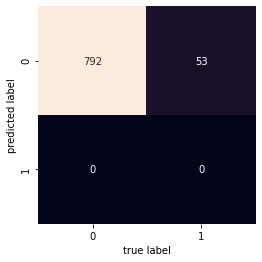

In [ ]:
#build a confusion matrix to visualize the performance of the model using seaborn
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test1, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test1,labels))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       792
           1       0.00      0.00      0.00        53

    accuracy                           0.94       845
   macro avg       0.47      0.50      0.48       845
weighted avg       0.88      0.94      0.91       845



/home/vix/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **K-Nearest Neighbours Algorithm**

Input X and output Y are from the Naive Bayes exercise ( We are continuing with the same dataset)

In [ ]:
#standardizing the input
x_std = (X-X.mean())/(X.std()) 

In [ ]:
x_std.head()

,Average Wind Speed,Average Temperature,Temeperature at 85 hpa,Relative Humidity at 85hpa,Sea Level Pressure,Precipitation
0,0.900540,-1.232637,-1.439033e+00,-1.848735e+00,3.223948e+00,-0.282386
1,1.244673,-0.449352,-9.576318e-01,-1.294890e+00,2.154494e+00,-0.282386
2,1.359384,-0.316341,-9.576318e-01,-6.851811e-02,1.376709e+00,-0.282386
3,1.015251,-0.316341,-7.692575e-01,1.236974e+00,5.989245e-01,1.296436
4,-0.017148,0.038354,-7.436000e-16,5.709709e-15,-2.829564e-13,0.157862


In [ ]:
x_std. describe()

,Average Wind Speed,Average Temperature,Temeperature at 85 hpa,Relative Humidity at 85hpa,Sea Level Pressure,Precipitation
count,2.534000e+03,2.534000e+03,2.534000e+03,2.534000e+03,2.534000e+03,2.534000e+03
mean,-2.142284e-15,-2.710381e-14,-1.116006e-15,5.849219e-15,-2.733837e-13,9.141158e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.196657e+00,-3.035670e+00,-4.327439e+00,-2.244339e+00,-3.678891e+00,-2.823860e-01
25%,-7.054143e-01,-6.414783e-01,-6.018136e-01,-7.014841e-01,-6.649756e-01,-2.823860e-01
50%,-1.714831e-02,8.269076e-02,1.098227e-01,1.688441e-01,-8.163709e-02,-2.823860e-01
75%,5.564067e-01,8.364178e-01,7.795981e-01,8.413704e-01,5.017014e-01,-2.444335e-01
max,4.686003e+00,1.885724e+00,2.286593e+00,1.672138e+00,3.612840e+00,1.539197e+01


In [ ]:
#split the data into train and test. Test data=1/3(total data)
X_train,X_test,y_train,y_test = train_test_split(x_std,Y,test_size=1/3,random_state=42) #set random state to any integer for reproducibilty

In [ ]:
#import KNeighboursClassifier from the sklearn library
from sklearn.neighbors import KNeighborsClassifier
test_scores = []
train_scores = []

#run this for loop to find the best k value
for i in range(1,15):
    #for the current loop assign k=i
    knn = KNeighborsClassifier(i)
    #the training data
    knn.fit(X_train,y_train)
    #predict the class label for the training data
    pred_y_train=knn.predict(X_train)
    #get the training accuracy
    train_accuracy=accuracy_score(pred_y_train,y_train)
    #append the training accuracy at a particular k value to the list.
    train_scores.append(train_accuracy)

    #predict the class label for test data
    pred_y_test=knn.predict(X_test)
    #get the test accuracy
    test_accuracy=accuracy_score(pred_y_test,y_test)
    #append the test accuracy at a particular k value to the list.
    test_scores.append(test_accuracy)

In [ ]:
train_scores

[1.0,
 0.9508584961515689,
 0.9538188277087034,
 0.9413854351687388,
 0.9425695677915926,
 0.9360568383658969,
 0.9396092362344582,
 0.9402013025458852,
 0.9425695677915926,
 0.9384251036116045,
 0.9402013025458852,
 0.9390171699230314,
 0.9396092362344582,
 0.9384251036116045]

In [ ]:
test_scores

[0.9136094674556213,
 0.9396449704142011,
 0.9313609467455621,
 0.9396449704142011,
 0.9337278106508876,
 0.9384615384615385,
 0.9349112426035503,
 0.9396449704142011,
 0.9372781065088758,
 0.9372781065088758,
 0.9349112426035503,
 0.9372781065088758,
 0.9349112426035503,
 0.9349112426035503]

/home/vix/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vix/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Accuracy')

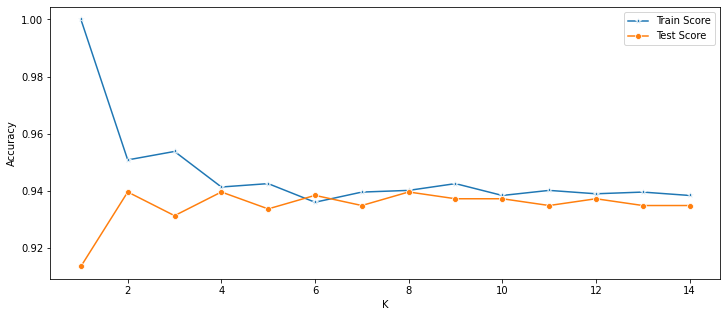

In [ ]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,15),test_scores,marker='o',label='Test Score')
plt.xlabel("K")
plt.ylabel("Accuracy")

Looking at the Plot we can see that best performance of the knn classifier is at k=4. Both training score and test score are close to each other and also maximum for the test score. Hence we set up our knn classifier with k=4.


In [ ]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(4)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.9396449704142011

In [ ]:
#select a sample from the test data to predict the output using the developed knn classifier, just selecting one row corresponds to a one set of coniditons 
t=X_test.values[0]

In [ ]:
t

array([ 0.67111772,  0.73296504,  0.25633606,  0.08972338, -0.47052942,
       -0.28238597])

In [ ]:
print("Predicted Class: ",knn.predict(t.reshape(1,-1)))
print("True Class: ",y_test[0])

Predicted Class:  [0]
True Class:  0


The accuracy alone is not  good enough to measure the classifier's performance. We have studied other metrics like precision, recall and f-score in the class, so let us look at how to calculate these metrics.

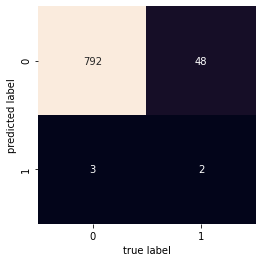

In [ ]:
y_pred = knn.predict(X_test)
#build a confusion matrix to visualize the performance of the model using seaborn
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');